In [1]:
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
import os
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [4]:
class AnomalyDetector:
    def __init__(self, n_components=1, covariance_type='full', k_threshold_std_dev=3, concat = True):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.k_threshold_std_dev = k_threshold_std_dev
        self.gmm = None
        self.X = np.array([])
        self.concat = concat

    def fit(self, X):
        """
        Fit the Gaussian Mixture Model to the training data.
        """
        
        if self.gmm is None:
            self.gmm = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type)
            self.gmm.fit(X)
            self.X = X
        else:
            self.X = np.concatenate((self.X, X), axis=0)
            if self.concat :
                self.gmm.fit(self.X)
            else:
                self.gmm.fit(X)
            
        # This tells the GMM to initialize the model parameters using the k-means algorithm, which can be more efficient than the default random initialization for large datasets

    def predict(self, X_test):
        """
        Predict whether the data is anomalous or not based on the GMM.
        """
        scores = self.gmm.score_samples(self.X)
        k = self.k_threshold_std_dev
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        threshold = mean_score - k * std_score
        is_anomaly = self.gmm.score_samples(X_test) < threshold
        return is_anomaly

In the modified code, the AnomalyDetector class has been updated to support online learning. The fit method now allows the model to be updated with new data, while the predict method returns the anomaly predictions based on the updated model.

To use the updated AnomalyDetector class, you would first create an instance of the class and fit it to your initial training data:

In [5]:
normal_data = pd.read_csv('../data/combined_data.csv')
# anomalous_data = pd.read_csv('../anomalous_data/combined_anomalous.csv')


In [7]:
train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
# test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
# test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [8]:
train_data_features.feature_dataframe[0]

,current_1_mean,current_1_var,current_1_std,current_2_mean,current_2_var,current_2_std,current_3_mean,current_3_var,current_3_std,current_1_harmonic_2,...,current_3_harmonic_2,current_3_harmonic_3,current_3_harmonic_4,current_1_thd,current_2_thd,current_3_thd,current_1_rms,current_2_rms,current_3_rms,current_unbalance_
0,1987.6003,32783.557096,181.062302,2174.0711,33020.711316,181.716018,440.3539,75256.979553,274.330056,4729.0,...,4593.0,1735.474287,1735.474287,2.313372,6.785160,6.785160,1995.829459,2181.651337,518.807297,18.686054
1,1982.4803,33379.063118,182.699379,2165.3532,32815.538604,181.150596,435.3327,73915.736984,271.874488,4601.0,...,4497.0,1978.679105,1978.679105,2.206607,8.168106,8.168106,1990.880173,2172.916643,513.247411,18.875276
2,1980.2381,33015.768385,181.702417,2170.6435,32957.610569,181.542311,428.8870,74261.647196,272.509903,4543.0,...,4629.0,1518.676727,1518.676727,2.495040,5.604163,5.604163,1988.556109,2178.221182,508.132148,27.656414
3,1978.7542,33224.950477,182.277125,2170.5052,32863.028676,181.281628,428.6128,74053.162992,272.127108,4428.0,...,4692.0,1274.577577,1274.577577,2.406731,6.406529,6.406529,1987.131051,2178.061653,507.695470,20.568046
4,1982.3731,33032.491746,181.748430,2164.9059,33034.596305,181.754219,432.9330,74385.515663,272.737082,4556.0,...,4590.0,1681.609943,1681.609943,2.258590,7.369790,7.369790,1990.686388,2172.521311,511.672805,20.326629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,1981.0900,33103.129613,181.942655,2169.3031,32608.981529,180.579571,436.4242,75003.547809,273.867756,4468.0,...,4574.0,1752.847683,1752.847683,2.219257,7.937776,7.937776,1989.426402,2176.805380,515.230172,20.261872
313,1984.3788,33107.962507,181.955936,2165.6269,32697.299226,180.823945,429.8828,74541.981862,273.023775,4455.0,...,4598.0,1629.288495,1629.288495,2.258475,7.360745,7.360745,1992.702656,2173.162189,509.248220,27.362831
314,1981.1716,33125.368090,182.003758,2166.5496,32823.523692,181.172635,430.5510,74550.616861,273.039588,4463.0,...,4573.0,1735.114117,1735.114117,2.229874,7.786725,7.786725,1989.513248,2174.110717,509.820876,26.060691
315,1983.0589,33408.837915,182.780847,2165.2676,32843.622352,181.228095,429.9598,73998.240808,272.026177,4487.0,...,4675.0,1332.334793,1332.334793,2.528244,5.462741,5.462741,1991.463808,2172.837803,508.779196,25.601103


In [34]:
# TODO adjust sensitivity
anomaly_detector = AnomalyDetector(n_components=1, covariance_type='full', k_threshold_std_dev=3)


In [35]:
ct = 2
it = iter(train_scaled)
try:
    while True:
        if anomaly_detector.gmm is None:
            data = [next(it), next(it)] #if the model is being fit for the first time
        else :
            data = [next(it)]
            ct += 1
        anomaly_detector.fit(data)
        anomaly_predictions = anomaly_detector.predict(data)
        if any(anomaly_predictions):
            print(f'anomalous {ct}')
        else:
            # print('not anomalous')
            pass

except StopIteration:
    pass


anomalous 96
anomalous 117
anomalous 166
anomalous 167
anomalous 194
anomalous 230
anomalous 243
anomalous 255
anomalous 285


These are the anomalies predicted whilst training on the data on the go

In [36]:
anomaly_scores = anomaly_detector.predict(train_scaled)

array([116, 242, 284], dtype=int64)

These are predicted after the whole dataset was trained

Finally, you can use the predict method to get anomaly predictions for your test data:

In [40]:
anomaly_predictions = anomaly_detector.predict(test_scaled)
np.where(anomaly_predictions == 1)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

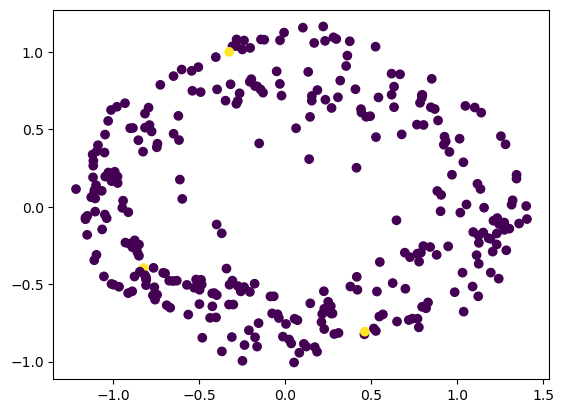

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()

Fitting the model using raw data

In [27]:
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)

using MinMaxScaler()


In [28]:
train_scaled = train_scaler.transform(normal_data)
anomalous_scaled = train_scaler.transform(anomalous_data)


In [29]:
anomaly_detector = modules.GaussianMixtureModel(n_components=1, covariance_type='full', k_threshold_std_dev=3,concat=False)

In [8]:
anomaly_detector = AnomalyDetector(n_components=1, covariance_type='full', k_threshold_std_dev=3,concat=False)


fitting the model file by file

In [30]:
from tqdm import tqdm

for i in tqdm(range(0,len(train_scaled),10000)):
    anomaly_detector.fit(train_scaled[i:i+10000])

100%|██████████| 317/317 [00:13<00:00, 22.79it/s]


In [31]:
import pickle
pickle.dump(anomaly_detector, open('../deployment/models/gmm_raw', 'wb'))



In [33]:
# load the model
loaded_model = pickle.load(open('../deployment/models/gmm_raw', 'rb'))

# use the model to make predictions
result = loaded_model.predict_anomalies(train_scaled)


In [34]:
len(np.where(result == True)[0])

36409

In [20]:
loaded_model.fit(train_scaled)

In [21]:
result = loaded_model.predict(train_scaled)
len(np.where(result == True)[0])

33501

In [19]:
test_scores = anomaly_detector.predict(train_scaled)

In [20]:
len(np.where(test_scores == 1)[0])


36409

In [31]:
len(np.unique(np.abs((anomaly_detector.gmm.predict(train_scaled)))))

2

In [21]:
anomaly_scores = anomaly_detector.predict(anomalous_scaled )


In [22]:
len(np.where(anomaly_scores == 1)[0])


2853390

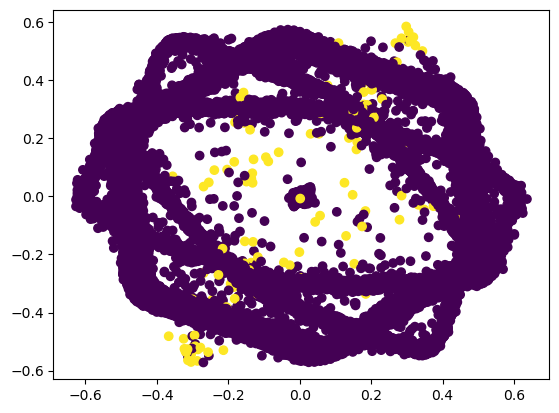

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assuming you have already scaled and preprocessed the data and stored it in variable X

pca = PCA(n_components=2)
X_2d = pca.fit_transform(train_scaled)

# assuming you have already fit the anomaly detection model and stored it in variable anomaly_detector
anomaly_predictions = anomaly_detector.predict(train_scaled)

# scatter plot of the data points colored by anomaly label
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=anomaly_predictions)
plt.show()